# Модель прогнозирования стоимости жилья для агентства недвижимости

In [173]:
import pandas as pd
import numpy as np
import json
import re
import sys
import random

#импортируем инструменты экспресс анализа данных
import sweetviz as sv
from ydata_profiling import ProfileReport

# импортируем библиотеки для визуализации и отключаем уведомления
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#стат тесты
import scipy as sp
from scipy. stats import ttest_ind
from itertools import chain
from itertools import combinations

# импортируем модели и метрики для моделей
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm.notebook import tqdm
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
# создадим универсальную функцию для определения выбросов при обработке данных, подробнее про поиск выбросов с помощью iqr https://www.codecamp.ru/blog/remove-outliers-python/

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

# методом Z-оценки - https://wedx.ru/obnaruzhenie-anomalij-vyyavlenie-vybrosov-v-dannyh.html#:~:text=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%20Z%2DScore%20%E2%80%94%20%D1%8D%D1%82%D0%BE%20%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9,%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%BE%20%D1%81%D1%82%D0%B0%D0%BD%D0%B4%D0%B0%D1%80%D1%82%D0%BD%D1%8B%D1%85%20%D0%BE%D1%82%D0%BA%D0%BB%D0%BE%D0%BD%D0%B5%D0%BD%D0%B8%D0%B9%2C%20%D1%81%D1%87%D0%B8%D1%82%D0%B0%D1%8E%D1%82%D1%81%D1%8F%20%D0%B2%D1%8B%D0%B1%D1%80%D0%BE%D1%81%D0%B0%D0%BC%D0%B8

def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

In [3]:
data = pd.read_csv('D:\IDE\диплом\diplom\project\data2.csv')

### <center> 4 Исследование и проектирование признаков

<b>4.1 Признак "state" </b>

In [4]:
# выведем кол-во уникальных значений в столбце
data["state"].nunique()

39

In [5]:
# выведем кол-во пустых значений в столбце
data["state"].isnull().sum()

0

In [6]:
# выведем уникальные значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой 
data["state"].value_counts(normalize=True).round(4) * 100

FL    30.15
TX    23.86
NC     6.24
TN     5.17
CA     5.11
NY     4.77
WA     3.68
OH     3.63
IL     2.46
NV     2.42
GA     1.85
CO     1.82
PA     1.56
MI     1.18
DC     1.16
AZ     1.02
IN     0.95
OR     0.79
UT     0.37
MA     0.33
MD     0.29
VT     0.25
MO     0.25
VA     0.21
NJ     0.13
WI     0.13
IA     0.07
ME     0.07
KY     0.03
OK     0.01
MS     0.01
SC     0.01
MT     0.00
DE     0.00
Fl     0.00
BA     0.00
AL     0.00
OT     0.00
OS     0.00
Name: state, dtype: float64

In [7]:
#Выделим топ 7 значений, остальные редкие значения заполним категорией other (слишком маленькая доля, будет негативно сказываться при обучении модели)
top_7_state = data["state"].value_counts(normalize = True).nlargest(7).index
data["state"] = data["state"].apply(lambda x: x if x in top_7_state else 'other')
# Выведем полученное распределение по сформированным группам
data["state"].value_counts(normalize=True).round(4) * 100

FL       30.15
TX       23.86
other    21.03
NC        6.24
TN        5.17
CA        5.11
NY        4.77
WA        3.68
Name: state, dtype: float64

<AxesSubplot: xlabel='target', ylabel='state'>

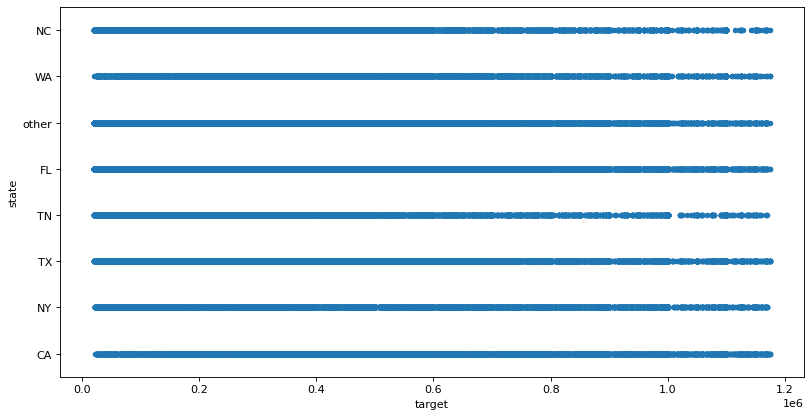

In [8]:
fig, ax = plt.subplots(figsize=(12, 6), dpi = 80)
sns.stripplot(data=data, x="target", y="state", dodge=True, jitter=False)

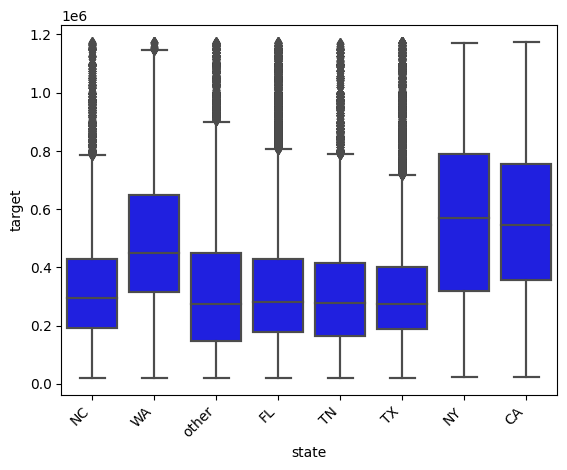

In [9]:
sns.boxplot(x='state', y='target', data=data)
sns.boxplot(
    x='state', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

> ***Выводы***

Признак "state" - качественно заполнен, отсутвуют пустые значения. 

В ходе обработки данных выведелено ТОП 7 значений, которые имеют долю около 79% от общего кол-во данных. Штаты, которые имеют низкую долю от общего кол-ва заменены на категорию "other". 

Это сделано для того, чтобы 

1) не получить слишком разреженную матрицу при кодировании признаков с помощью One-Hot Encoding.

2) на основании графиков распределения по штатам, без снижения кол-ва признаков данные по штатам имеют смещение распределения, что будет снижать качество модели

<b>4.2 Признак "city" </b>

In [10]:
# выведем кол-во уникальных значений в столбце
data["city"].nunique()

1930

In [11]:
#приведем к нижнему регистру и удалим пробелы в конце и начале строки 
data['city'] = data['city'].str.lower()
data['city'] = data['city'].str.strip()

In [12]:
# выведем кол-во уникальных значений в столбце после предобработки
data["city"].nunique()

1823

In [13]:
# выведем кол-во пустых значений в столбце
data["city"].isnull().sum()

19

In [14]:
# выведем ТОП-50 значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой
data["city"].value_counts(normalize=True).round(4).head(20) * 100

houston            6.86
san antonio        4.64
miami              4.14
jacksonville       2.92
dallas             2.32
orlando            2.06
chicago            1.89
charlotte          1.87
tampa              1.83
las vegas          1.72
fort worth         1.65
cleveland          1.43
austin             1.38
nashville          1.37
philadelphia       1.36
brooklyn           1.30
fort lauderdale    1.19
kissimmee          1.19
washington         1.16
atlanta            1.10
Name: city, dtype: float64

> ***Примечание***

Мы видим 21 город, которые имеют относительно высокую долю от общего кол-ва в датафрейме (более 1% от общего кол-во). Общее кол-во городов составляет 1855.

In [15]:
#Выделим топ 21 значений, остальные редкие значения заполним категорией other (слишком маленькая доля, будет негативно сказываться при обучении модели)
top_21_city = data["city"].value_counts(normalize = True).nlargest(21).index
data["city"] = data["city"].apply(lambda x: x if x in top_21_city else 'other')
# Выведем полученное распределение по сформированным группам
data["city"].value_counts(normalize=True).round(4) * 100

other              55.63
houston             6.86
san antonio         4.64
miami               4.14
jacksonville        2.92
dallas              2.32
orlando             2.06
chicago             1.89
charlotte           1.87
tampa               1.83
las vegas           1.72
fort worth          1.65
cleveland           1.43
austin              1.38
nashville           1.37
philadelphia        1.36
brooklyn            1.30
fort lauderdale     1.19
kissimmee           1.19
washington          1.16
atlanta             1.10
seattle             0.99
Name: city, dtype: float64

<AxesSubplot: xlabel='target', ylabel='city'>

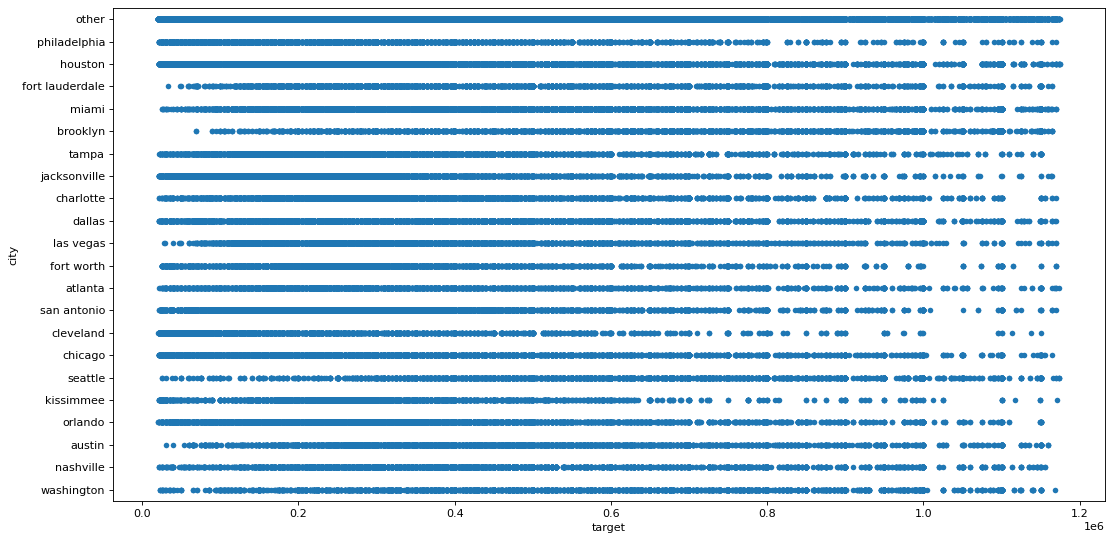

In [16]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=80)
sns.stripplot(data=data, x="target", y="city", dodge=True, jitter=False)

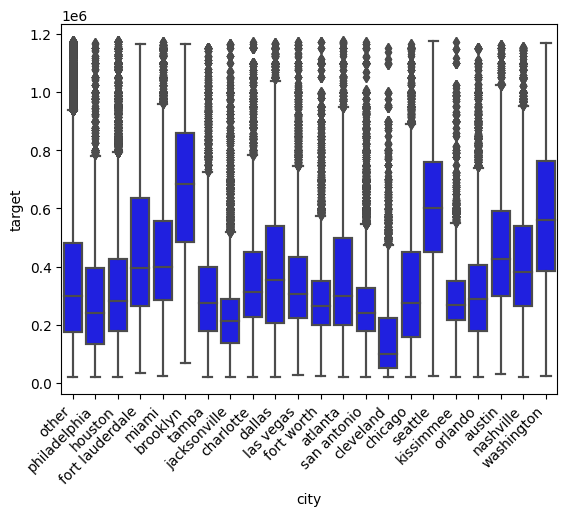

In [17]:
sns.boxplot(x='city', y='target', data=data)
sns.boxplot(
    x='city', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

> ***Выводы***

Признак "city" - качественно заполнен, отсутвуют пустые значения. 

В ходе обработки данных выведелено ТОП 21 значений, которые имеют долю около 44% от общего кол-во данных (признак имеет длинный хвост из большого кол-ва названий с низкой отдельной долей каждого уникального значения)

<b>4.3 Признак "private_pool" </b>

Признак "private_pool" обозначает наличие бассейна.

In [18]:
# выведем кол-во уникальных значений в столбце
data["private_pool"].nunique()

2

In [19]:
# выведем значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой
data["private_pool"].value_counts(normalize=True).round(4).head(50) * 100

yes    65.55
Yes    34.45
Name: private_pool, dtype: float64

In [20]:
#приведем к нижнему регистру
data['private_pool'] = data['private_pool'].str.lower()

In [21]:
# выведем кол-во пустых значений в столбце
data["private_pool"].isnull().sum()

289605

In [22]:
# заполним пустые значения nо
data['private_pool'] = data['private_pool'].fillna('no')

In [23]:
# выведем значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой
data["private_pool"].value_counts(normalize=True).round(4).head(50) * 100

no     89.28
yes    10.72
Name: private_pool, dtype: float64

Text(0, 0.5, 'count')

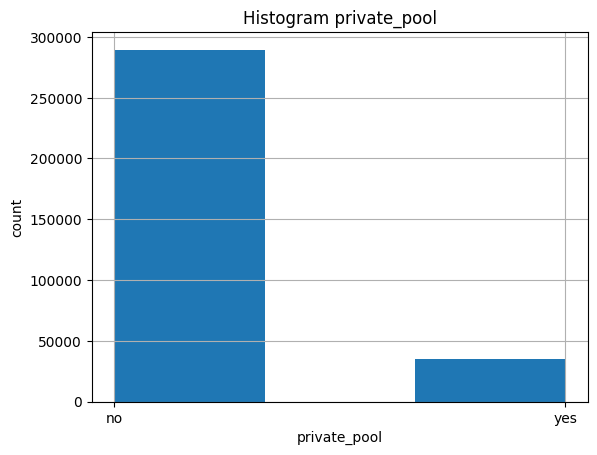

In [24]:
# Построим гистограмму для оценки распределения
data["private_pool"].hist(bins=3)
plt.title('Histogram private_pool')
plt.xlabel('private_pool')
plt.ylabel('count')

<AxesSubplot: xlabel='target', ylabel='private_pool'>

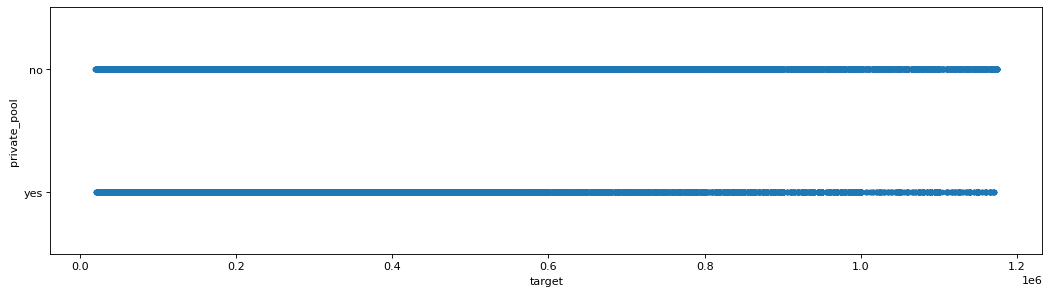

In [25]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=80)
sns.stripplot(data=data, x="target", y="private_pool", dodge=True, jitter=False)

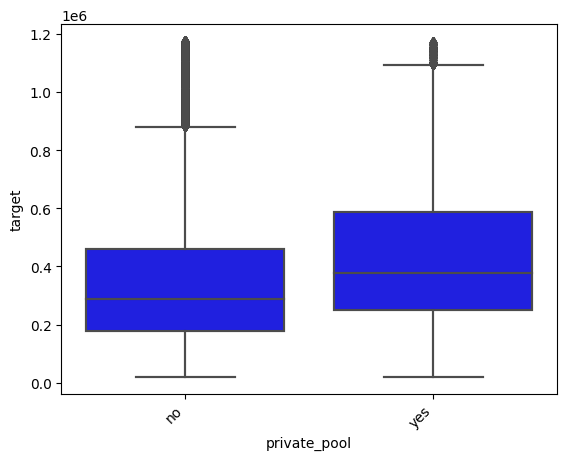

In [26]:
sns.boxplot(x='private_pool', y='target', data=data)
sns.boxplot(
    x='private_pool', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

> ***Выводы***

Признак "private_pool" - содержал данные из 2 столбцов, около 88% строк было не заполнено. Логично предположить, что бассейн есть не везде и пропуски это объекты без бассейна.

После обработки данных пропуски были заменены на категорию 'no'.

Распределение плотности по private_pool показывает, что цена распределены в 2 категориях равномерно.

#### 4.4 Признак "status"

За основу классификации статусов недвижимости будем использовать информацию с ресурса https://www.bostonmove.com/listing-status/, адаптированную к нашим данным
 
##### **1 На рынке**

`Скоро появится (Coming Soon)`
Недвижимость готовится к продаже, но не готова к показу. Объявления со статусом "В ближайшее время" могут не отображаться, пока объявление не находится в активном состоянии.


`Новый (NEW)`
Недвижимость помечается как новая в течение первых 3 дней на MLS. Через 3 дня статус объявления меняется на АКТИВНЫЙ. 

`Активен (ACT/Aсtive)`
Недвижимость, отмеченная как АКТИВНАЯ, будет доступна для покупки или аренды на MLS. 

`Изменение цены (Price Change/PCG)`
Когда агент по листингу изменяет цену листинга (выше или ниже), это будет указано как ИЗМЕНЕНИЕ ЦЕНЫ в течение 3 дней. Через 3 дня оно вернется в АКТИВНЫЙ статус. 

`Возвращение на рынок (Back on Market/BOM)`
Когда листинг попадает под ДЕЙСТВИЕ соглашения и сделка разваливается, сначала он будет включен в список "СНОВА На РЫНКЕ" на 3 дня. Через 3 дня он вернется к АКТИВНОМУ статусу.

`Продлено (Extended/EXT)`
Когда агент перечисляет недвижимость, у него есть письменное соглашение на определенный период времени о включении этой недвижимости в список. Когда список отображается как РАСШИРЕННЫЙ, это просто означает, что агент по листингу продлил свое соглашение о листинге до истечения срока его действия. 

`Возобновлено (Reactivated/RAC)`
Как и в случае с РАСШИРЕННЫМ статусом, РЕАКТИВИРОВАННЫЙ - это когда срок действия соглашения агента о листинге истек. 

`Контингент (CTG)`
В большинстве случаев агенты по листингу больше не показывают УСЛОВНЫЕ объекты, а если и показывают, то только для резервного копирования. УСЛОВНАЯ недвижимость, как правило, имеет принятое предложение по ней, однако они пока не могут включить ее в список ПО СОГЛАШЕНИЮ, потому что это зависит от осмотра дома, проверки адвокатом, оценки, финансирования, одобрения третьей стороной (краткосрочные продажи / взыскания) или купли-продажи (P & S). Как только будут устранены непредвиденные обстоятельства, листингу будет присвоен статус "СОГЛАСНО СОГЛАШЕНИЮ".

`В ожидании (Pending)` Все непредвиденные обстоятельства устранены, и объект готов к закрытию

##### **2 Вне рынка**

`По соглашению (Under Agreement/UAG)`
Обе стороны подписали соглашение о купле-продаже (или аренде). Очень редко такой листинг возвращается на рынок. Эти объявления, как правило, больше не доступны для показа, но еще не полностью закрыты.

`Продано (Sold/SLD)`
ПРОДАННАЯ недвижимость означает, что право собственности перешло, сделка завершена, и недвижимости больше нет на рынке.

`Сдается в аренду (Rented/RNT)`
АРЕНДОВАННАЯ недвижимость означает, что договор аренды подписан, и недвижимости больше нет на рынке.

`Отозван (Withdrawn/WDN)`
ОТОЗВАННЫЙ листинг - это листинг, который временно был снят с продажи, но не удален полностью. Изъятая недвижимость может быть доступна, а может и нет, поэтому лучше уточнить наличие у вашего агента.

`Срок действия истек (Expired/EXP)`
Когда срок действия соглашения о листинге агента по листингу истекает, недвижимость указывается как ПРОСРОЧЕННАЯ. Если агент по листингу подпишет новый контракт в течение 10 дней, она вернется на рынок как ПОВТОРНО АКТИВИРОВАННАЯ и будет доступна. Однако, если свойство не будет повторно активировано, срок его действия в MLS останется истекшим. Если по истечении 10 дней недвижимость вернется на рынок, она будет указана как НОВАЯ.

`Отменено (Cancelled/)`
Когда владелец и агент имеют взаимное соглашение о расторжении договора листинга, он может быть АННУЛИРОВАН. Аннулированных списков больше нет на рынке.

In [27]:
#приведем к нижнему регистру
data['status'] = data['status'].str.lower()

In [28]:
#если содержит подстроку 'coming' ('скоро появится'), заменим на 'coming soon'
data.loc[data['status'].str.contains('coming',  na= False), "status"] = 'coming soon'

#если содержит подстроку 'for rent' ('аренда'), заменим на 'for rent'
data.loc[data['status'].str.contains('for rent',  na= False), "status"] = 'for rent'

#если содержит подстроку 'pending', заменим на 'pending / pending continue to show'
data.loc[data['status'].str.contains('pending',  na= False), "status"] = 'pending / pending continue to show'

#если содержит подстроку 'sold', заменим на 'sold' ('продано')
data.loc[data['status'].str.contains('sold',  na= False), "status"] = 'sold'

#если содержит подстроку 'backup', заменим на 'under contract backups' ('продано')
data.loc[data['status'].str.contains('backup',  na= False), "status"] = 'under contract backups'

# продажа недвижимости с помощью аукциона
data.loc[data["status"] == " / auction", "status"] = "auction"
data.loc[data["status"] == "auction - active", "status"] = "auction"
data.loc[data["status"] == "active - auction", "status"] = "auction"

# лишён права выкупа
data.loc[data["status"] == "foreclosed", "status"] = "foreclosure"
data.loc[data["status"] == "contingent   foreclosure", "status"] = "foreclosure"

# недвижимость в настоящее время находится на рынке и доступна для продажи
data.loc[data["status"] == "a active", "status"] = "active"
data.loc[data["status"] == "temporary active", "status"] = "active" 

# предложение о покупке уже сделано, но не принято продавцом окончательно, 
# недвижимость продолжают показывать другим потенциальным покупателям
data.loc[data["status"] == "under contract show", "status"] = "under contract showing"
data.loc[data["status"] == "under contract   showing", "status"] = "under contract showing"
data.loc[data["status"] == "active under contract", "status"] = "under contract showing"
data.loc[data["status"] == "under contract", "status"] = "under contract showing"
data.loc[data["status"] == "u under contract", "status"] = "under contract showing"
data.loc[data["status"] == "under contract - show", "status"] = "under contract showing"
data.loc[data["status"] == "contract p", "status"] = "under contract showing"
data.loc[data["status"] == "contract", "status"] = "under contract showing"
data.loc[data["status"] == "uc continue to show", "status"] = "under contract showing"
data.loc[data["status"] == "c continue show", "status"] = "under contract showing"

# продавцу/покупателю для завершения сделки необходимо выполнить какие-то условия
data.loc[data["status"] == "active contingency", "status"] = "contingent" 
data.loc[data["status"] == "active/contingent", "status"] = "contingent"
data.loc[data["status"] == "active with contingencies", "status"] = "contingent"
data.loc[data["status"] == "active - contingent", "status"] = "contingent"
data.loc[data["status"] == "conditional contract", "status"] = "contingent"
data.loc[data["status"] == "contingent   release", "status"] = "contingent"
data.loc[data["status"] == "contingent - financing", "status"] = "contingent"
data.loc[data["status"] == "contingent - sale of home", "status"] = "contingent"
data.loc[data["status"] == "contingent finance and inspection", "status"] = "contingent"
data.loc[data["status"] == "active contingent", "status"] = "contingent"
data.loc[data["status"] == "contract contingent on buyer sale", "status"] = "contingent" # зависит от продажи дома покупателя
data.loc[data["status"] == "contingent lien holder release", "status"] = "contingent"
data.loc[data["status"] == "contingency 48 hr (+/ )", "status"] = "contingent"
data.loc[data["status"] == "contingent show", "status"] = "contingent"
data.loc[data["status"] == "contingent   show", "status"] = "contingent"
data.loc[data["status"] == "contingent show", "status"] = "contingent"
data.loc[data["status"] == "contingent escape", "status"] = "contingent" #"оговорка об освобождении" 

#создадим категорию 'другое' и заменим часто встрпечающее значение, которое нельзя однозначно интепретировать
data.loc[data["status"] == "p", "status"] = "other"

> ***Пояснение***

Основная обработка данных производится в правилах для которых указан комментарий "если содержит подстроку". Этих правил достатчно, чтобы добиться приемлимого качества обработки данных.

Ручное заполнение данных по правилам, которые расположены ниже - позволяют исправить наиболее распостраненные опечатки, сокращение, распространеные жаргонизмы в отрасли на корректные категории, которые не относятся к прочим. Дает небольшое увеличение точности прогнозирования модели.

In [29]:
data["status"].value_counts(normalize=True) * 100

for sale                                59.998894
active                                  30.763037
foreclosure                              1.778080
pending / pending continue to show       1.688917
new construction                         1.641916
under contract showing                   1.098297
pre-foreclosure                          0.682548
other                                    0.461022
auction                                  0.439595
pre-foreclosure / auction                0.437867
contingent                               0.350087
new                                      0.208047
price change                             0.175216
under contract backups                   0.108171
back on market                           0.037670
coming soon                              0.034905
option contract                          0.018662
active with offer                        0.014861
pi                                       0.012441
c                                        0.012096


In [30]:
#удалим имущество для сдачи в аренду, рассчитываем стоимость только объектов недвижимости, выставленных на продажу
data = data.loc[data["status"] != "for rent"]

In [31]:
#Выделим топ 10 статусов, остальные редкие словосочетания заполним категорией other (слишком малькое значение)
top_10 = data["status"].value_counts(normalize = True).nlargest(10).index
data["status"] = data["status"].apply(lambda x: x if x in top_10 else 'other')
# Выведем полученное распределение по сформированным группам
data["status"].value_counts()

for sale                              173611
active                                 89015
other                                  39275
foreclosure                             5145
pending / pending continue to show      4887
new construction                        4751
under contract showing                  3178
pre-foreclosure                         1975
auction                                 1272
pre-foreclosure / auction               1267
Name: status, dtype: int64

<AxesSubplot: xlabel='target', ylabel='status'>

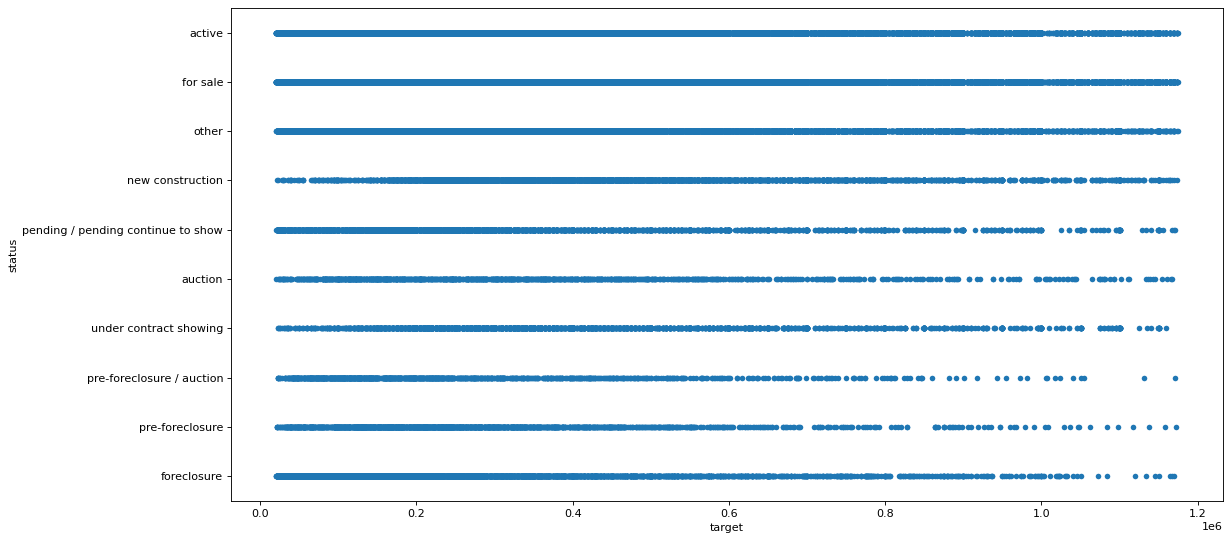

In [32]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=80)
sns.stripplot(data=data, x="target", y="status", dodge=True, jitter=False)

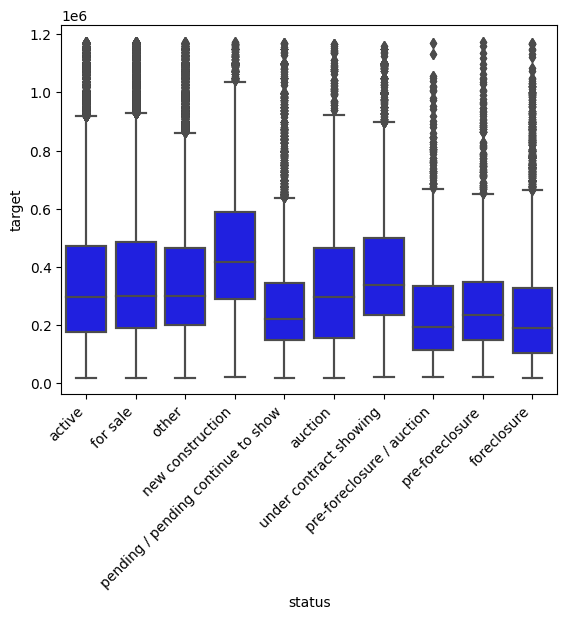

In [33]:
sns.boxplot(x='status', y='target', data=data)
sns.boxplot(
    x='status', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

> ***Выводы***

Признак "status" - содержал большое кол-во не структурированных данных, ошибки, опечатки. 

После обработки данных пропуски и данные с низкой удельной долей были заменены на категорию 'other'. Кол-во категорий подбиралось с учетом распределения цен по группам.

#### 4.5 Признак "fireplace"

Признак fireplace - обозначает наличие камина

In [34]:
#приведем к нижнему регистру
data['fireplace'] = data['fireplace'].str.lower()

In [35]:
# выведем кол-во уникальных значений в столбце
data["fireplace"].nunique()

1392

In [36]:
# выведем кол-во пустых значений в столбце
data["fireplace"].isnull().sum()

236537

In [37]:
# выведем значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой
data["fireplace"].value_counts(normalize=True).round(4).head(50) * 100

yes                                                                         68.02
1                                                                           15.40
not applicable                                                               2.26
2                                                                            1.93
fireplace                                                                    0.81
living room                                                                  0.45
wood burning                                                                 0.34
fireplace yn                                                                 0.32
1 fireplace                                                                  0.31
no                                                                           0.31
gas/gas logs                                                                 0.31
0                                                                            0.30
3               

In [38]:
# Логично предположить, что пропущенные значения - это объекты без камина. Обозначим их как "no"
data.fireplace = data.fireplace.fillna('no')

In [39]:
# 0 - камин отсутвует, так же обозначим их как "no"
data['fireplace'] = data['fireplace'].apply(lambda x: 'no' if x=='0' else x)

In [40]:
# Прочие названия отметит как наличие камина
data['fireplace'] = data['fireplace'].apply(lambda x: 'yes' if x!='no' else x)

In [41]:
# выведем значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой
data["fireplace"].value_counts(normalize=True).round(4).head(50) * 100

no     73.08
yes    26.92
Name: fireplace, dtype: float64

Text(0, 0.5, 'count')

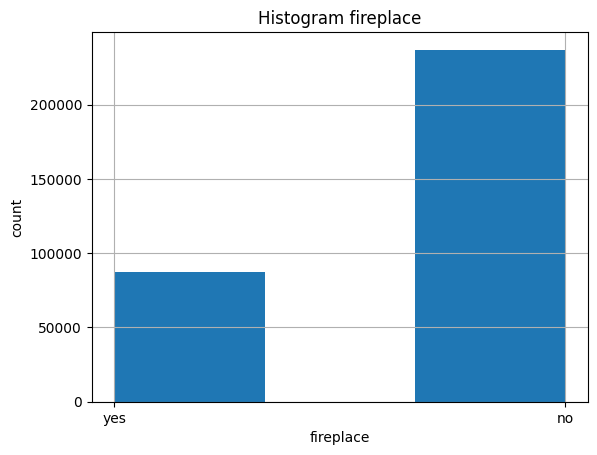

In [42]:
# Построим гистограмму для оценки распределения
data["fireplace"].hist(bins=3)
plt.title('Histogram fireplace')
plt.xlabel('fireplace')
plt.ylabel('count')

<AxesSubplot: xlabel='target', ylabel='fireplace'>

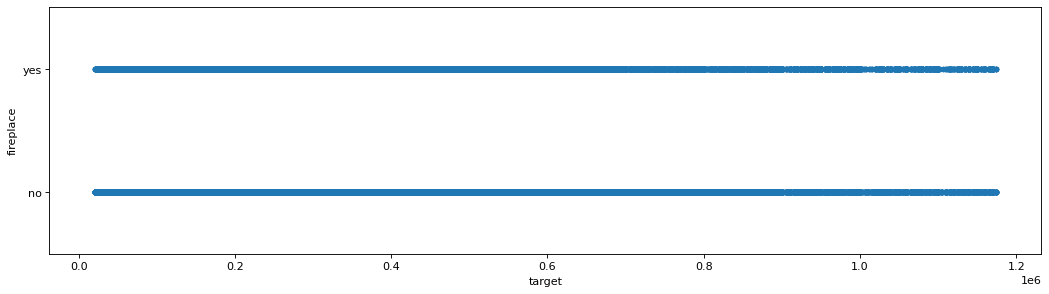

In [43]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=80)
sns.stripplot(data=data, x="target", y="fireplace", dodge=True, jitter=False)

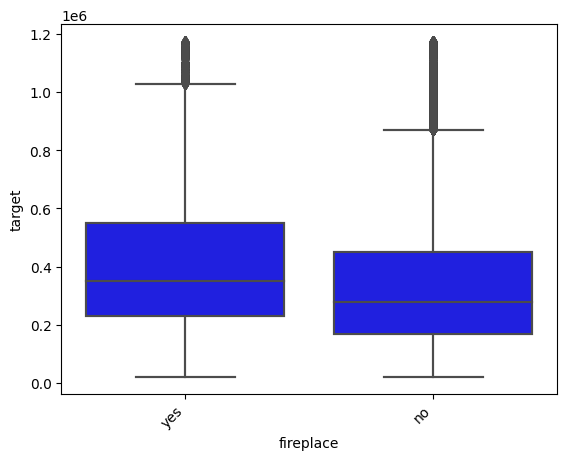

In [44]:
sns.boxplot(x='fireplace', y='target', data=data)
sns.boxplot(
    x='fireplace', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

> ***Выводы***

Признак "fireplace" - был приведен к бинарной классификации - есть или нет камина. Около 27% объектов имеют камин, 73% - нет.

Применено допущение, что отсувие данных в строке - это отсутствие камина, а заполнение данными кроме 0 и но, что камин присутствует. 

Распределение цен равномерно для данного бинарного признака.

#### 4.6 Признак "baths"

In [45]:
# выведем кол-во уникальных значений в столбце
data.baths.nunique()

158

In [46]:
# выведем уникальные значения для визуальной оценки
data['baths'].unique()

array(['3.5', '3 Baths', nan, '2', '3', '2 Baths', 'Bathrooms: 2',
       '1,750', '4 Baths', '2 ba', '1,000', '2.0', '3.0', 'Bathrooms: 1',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5',
       'Bathrooms: 4', '3 ba', '4.0', '6 Baths', '2,500', '5.5 Baths',
       '1.0', '1.5', '2.5', '4', '4,000', '5 Baths', '3.5 Baths', '2,000',
       '3,000', '1 ba', '0', '5.0', '1,500', '1,250', '2,250', '5.5',
       '7 Baths', '3,500', '1.5 Baths', '2,750', '~', 'Bathrooms: 5',
       '4.5 Baths', '750', 'Bathrooms: 6', '12 ba', '2.5+', '5.5+',
       '0 / 0', '5', '5 ba', '4 ba', 'Sq. Ft. ', '-- baths',
       'Bathrooms: 7', '6.0', '7', '3.5+', '1.5+', '6', '5,000',
       '1.75 Baths', 'Bathrooms: 8', '10', '8 Baths', '4.5+', '19 Baths',
       '13 Baths', '9', '1.1 Baths', '2.5 ba', 'Bathrooms: 12',
       '12 Baths', 'Bathrooms: 241', '6.5', '8 ba', '8.0', '6.5 Baths',
       '14 Baths', '3.5 ba', '11 Baths', '7,500+', '6.5+', '20 Baths',
       '7 ba', '9 Baths', '1-0 / 1-0 

In [47]:
#удалим буквы, пробелы, двоеточия, плюсы
data['baths'] = data['baths'].str.replace('[a-zA-Z+:]','')
data['baths'] = data['baths'].str.replace(' ','', regex=True)

#заменим вариации пропусков и нулевых значений и значения, содержащие знак /, на '0'
data['baths'] = data['baths'].replace(['', '~', '..', '--', '—','0.0','0.00','0/0'], 0)
data.loc[data["baths"].str.contains('/', na=False), 'baths'] = 0

In [48]:
#Выведем кол-во пустых значений
data.baths.isna().sum()

86763

In [49]:
#изменим тип данных
data['baths'] = data['baths'].str.replace(',', '.', regex=True).astype(float).round(0)

In [50]:
#Заменим пустые значения на 0
data.baths = data.baths.fillna(0)

In [51]:
#изменим тип данных
data['baths'] = data['baths'].astype(int)

In [52]:
#Выведем кол-во пустых значений
data.baths.isna().sum()

0

In [53]:
# выведем значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой
data["baths"].value_counts(normalize=True).round(4).head(50) * 100

2      36.82
0      27.70
3      19.17
4       8.45
1       5.53
5       1.57
6       0.47
7       0.12
750     0.07
8       0.06
10      0.01
9       0.01
12      0.01
11      0.01
13      0.00
16      0.00
20      0.00
14      0.00
22      0.00
18      0.00
24      0.00
30      0.00
15      0.00
17      0.00
60      0.00
19      0.00
25      0.00
241     0.00
28      0.00
Name: baths, dtype: float64

In [54]:
data.reset_index(inplace = True, drop = True)

In [55]:
# Удалим выбросы
data = data.drop(outliers_iqr(data.baths))
data.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'count')

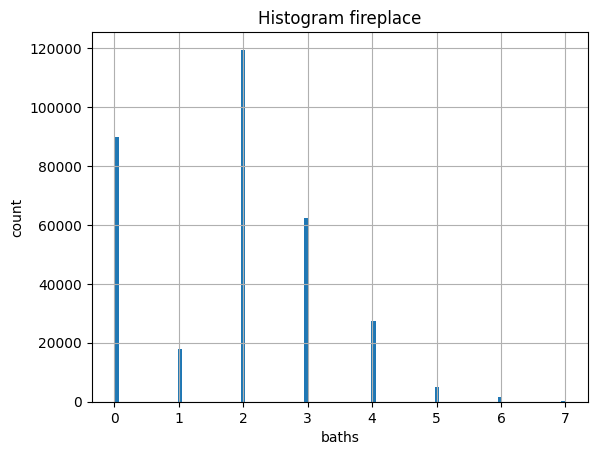

In [56]:
# Построим гистограмму для оценки распределения
data["baths"].hist(bins=100)
plt.title('Histogram fireplace')
plt.xlabel('baths')
plt.ylabel('count')

In [57]:
# выведем значения из столбца и их долю в процентах, ограничим точность 2 знаками после запятой
data["baths"].value_counts(normalize=True).round(4).head(50) * 100

2    36.88
0    27.75
3    19.20
4     8.46
1     5.54
5     1.57
6     0.47
7     0.12
Name: baths, dtype: float64

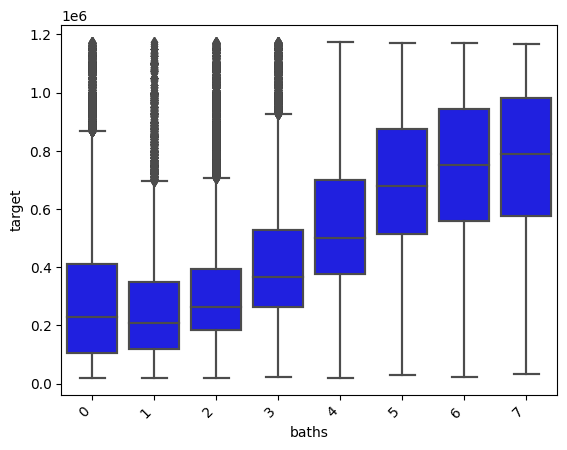

In [58]:
sns.boxplot(x='baths', y='target', data=data)
sns.boxplot(
    x='baths', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

> ***Выводы***

Признак "baths" - был преобразован к 7 категориям.

#### 4.7 Признак "property_type"

In [59]:
#Удалим пробелы в конце и начале, приведем строку к нижнему регистру
data['property_type'] = data['property_type'].str.lower()
data['property_type'] = data['property_type'].str.strip()

In [60]:
# заполним пропуски значением 'unknown'
data['property_type'] = data['property_type'].fillna('unknown')
data['property_type'] = data['property_type'].apply(lambda x: 'unknown' if x ==' ' or x=='' else x)

In [61]:
#Выведем ТОП 20 значений
data['property_type'].value_counts().head(20)

single-family home               81583
single family                    55358
condo                            36521
single family home               29388
unknown                          27019
townhouse                        17212
lot/land                         15444
condo/townhome/row home/co-op     7274
land                              7231
traditional                       5520
multi-family                      5449
coop                              2743
multi family                      2205
ranch                             1748
mobile/manufactured               1492
high rise                         1478
single detached, traditional      1475
detached, one story               1435
contemporary                      1391
1 story                           1230
Name: property_type, dtype: int64

In [62]:
type_list = list()

for index, value in data["property_type"].items():
        type = value
        type = type.split(" ', ' ")
        for i in type:
            type_list.append(i.strip())

In [63]:
# Выведем самые популярные типы, предварительно создав отдельный df
type_df = pd.DataFrame(data = type_list, columns = ["type_name"])
type_df= type_df.value_counts().rename_axis('type_name').reset_index(name = 'counts')
type_df.head(30)

,type_name,counts
0,single-family home,81583
1,single family,55358
2,condo,36521
3,single family home,29388
4,unknown,27019
5,townhouse,17212
6,lot/land,15444
7,condo/townhome/row home/co-op,7274
8,land,7231
9,traditional,5520


In [64]:
# Выделим отдельно уникальные значения данных, содержащих информацию об этажности, 
# для заполнения отсутствующих значений признака 'stories'
stories = type_df[type_df['type_name'].str.contains("stories|story|floors")]
stories['type_name'].unique()

array(['detached, one story', '1 story', '2 stories', 'one story',
       'detached, two story', '2 stories, traditional', '2 story',
       '1 story, traditional', 'two story', '2 stories, contemporary',
       '1 story, contemporary', 'low-rise (1-3 stories)',
       'ranch, one story', 'detached, ranch, one story',
       '1 story with basement',
       'detached, one story, spanish/mediterranean', '1 story, ranch',
       '1 story, historic/older', 'high-rise (8+ stories)',
       'detached, two story, spanish/mediterranean',
       '2 stories, mediterranean', '2 stories, historic/older',
       'manufactured house, ranch, one story', 'mid-rise (4-7 stories)',
       'less than 4 floors', '1 story, ranch, traditional',
       '2 stories, contemporary, traditional', '2 stories with basement',
       '3+ stories', '2 stories, texas hill country',
       'manufactured house, ranch, one story, manufactured home',
       '3+ stories, contemporary', 'one story, spanish/mediterranean',
  

In [65]:
# Создадим функцию для получения информации о количестве этажей 
def select_type(type):
    if "1" and "1/2" in type:
        return '1.5'
    if "2.5" in type:
        return '2.5'
    if "2 story" in type or "2 stories" in type or 'two' in type:
        return '2.0'
    if "1 story" in type or 'one' in type:
        return '1.0'
    if "low-rise" in type or "less than 4 floors" in type:
        return '1.0' # условимся, что в качестве значения принято минимально возможное количество этажей в данной категории
    if "3+" in type:
        return '3.0' # условимся, что в качестве значения принято минимально возможное количество этажей в данной категории
    if "mid-rise (4-7 stories)" in type or "4+ floors" in type:
        return '4.0' # условимся, что в качестве значения принято минимально возможное количество этажей в данной категории
    if "high-rise (8+ stories)" in type:
        return '8.0' # условимся, что в качестве значения принято минимально возможное количество этажей в данной категории
    
# Создадим новый признак "property_stories"
data["property_stories"] = data["property_type"].apply(select_type)

In [66]:
data.loc[(data['property_type'].str.contains('ranch|cape cod|bungalow')), 'property_stories'] = '1.0' # условимся, что в качестве значения принято 
                                                                               #минимально возможное количество этажей в данной категории
data.loc[(data['property_type'].str.contains('colonial|georgian')), 'property_stories'] = '2.0'

In [67]:
data['stories'] = data['stories'].fillna(data.pop('property_stories'))

In [68]:
data.loc[((data["property_type"].str.contains('wide|level')==False) & 
          (data['property_type'].str.contains('single'))), 'property_type'] = 'single family residence'
data.loc[((data["property_type"].str.contains('detached')) & 
          (data['property_type'].str.contains('apartment|duplex')==False)), 'property_type'] = 'single family residence'
data.loc[((data["property_type"].str.contains('garden')) & 
          (data['property_type'].str.contains('apartment')==False)), 'property_type'] = 'single family residence'
data.loc[((data["property_type"].str.contains('ranch|farms')) 
          & (data['property_type'].str.contains('duplex|manufactured|attached')==False)), 'property_type'] = 'single family residence'
data.loc[data["property_type"].str.contains('bungalow'), 'property_type'] = 'single family residence'
data.loc[data["property_type"].str.contains('with basement'), 'property_type'] = 'single family residence'
data.loc[data["property_type"].str.contains('1 story'), 'property_type'] = 'single family residence'


data.loc[data["property_type"].str.contains('mobile|manufactured'), 'property_type'] = 'manufactured home'
data.loc[(data["property_type"].str.contains('single')) 
         & (data["property_type"].str.contains('wide')), 'property_type'] = 'manufactured home'
data['property_type'] = data['property_type'].replace(['modular/prefab'], 'manufactured home')

data['property_type'] = data['property_type'].replace(['land', 'residential (<1 acre)'], 'lot/land')

#многоквартирные дома
data['property_type'] = data['property_type'].replace(['multi-family', 'multi-family home', 'multi family', 'cluster home', 
                                                       'duplex', 'triplex', 'fourplex'], 'multi family')

data.loc[((data["property_type"].str.contains('condo')) 
          & (data['property_type'].str.contains('townhome|townhouse')==False)), 'property_type'] = 'condo'
data.loc[((data["property_type"].str.contains('condo')) & 
          (data["property_type"].str.contains('townhome|townhouse')) 
          & (data['property_type'].str.contains('co-op|apartment')==False)), 'property_type'] = 'condo'

data.loc[((data["property_type"].str.contains('townhome|townhouse')) 
          & (data['property_type'].str.contains('condo')==False)), 'property_type'] = 'townhouse'

data.loc[((data["property_type"].str.contains('traditional')) 
  & (data['property_type'].str.contains('transitional|duplex')==False)), 'property_type'] = 'traditional'

data['property_type'] = data['property_type'].replace(['coop', 'co-op'], 'cooperative')


data.loc[data["property_type"].str.contains('historic'), 'property_type'] = 'historical'

In [69]:
type_list = list()

for index, value in data["property_type"].items():
        type = value
        type = type.split(" ', ' ")
        for i in type:
            type_list.append(i.strip())

In [70]:
type_df = pd.DataFrame(data = type_list, columns = ["type_name"])
type_df= type_df.value_counts().rename_axis('type_name').reset_index(name = 'counts')
type_df.head(19)

,type_name,counts
0,single family residence,176941
1,condo,37545
2,unknown,27019
3,lot/land,22762
4,townhouse,17388
5,multi family,8885
6,condo/townhome/row home/co-op,7274
7,traditional,6350
8,manufactured home,3356
9,cooperative,3250


In [71]:
#удалим категорию "земельные участки", рассчитываем стоимость только объектов недвижимости, выставленных на продажу
data = data.loc[data["status"] != "lot/land"]
type_df = type_df.loc[type_df['type_name'] != "lot/land"]

In [72]:
list_top = list(type_df['type_name'])
data["property_type"] = data["property_type"].apply(lambda x: x if x in list_top else 'unknown')

# Выведем полученное распределение по сформированным группам
data["property_type"].value_counts(normalize=True).round(4).head(50) * 100

single family residence          54.65
unknown                          15.37
condo                            11.60
townhouse                         5.37
multi family                      2.74
condo/townhome/row home/co-op     2.25
traditional                       1.96
manufactured home                 1.04
cooperative                       1.00
high rise                         0.46
contemporary                      0.43
colonial                          0.33
contemporary/modern               0.29
2 stories                         0.28
apartment                         0.19
florida                           0.16
transitional                      0.16
one story                         0.16
cape cod                          0.08
2 story                           0.08
other style                       0.07
spanish/mediterranean             0.07
craftsman                         0.06
two story                         0.05
other                             0.05
multiple occupancy       

In [73]:
#Выделим топ 10 статусов, остальные редкие словосочетания заполним категорией other (слишком малькое значение)
top_10_property_type = data["property_type"].value_counts(normalize = True).nlargest(10).index
data["property_type"] = data["property_type"].apply(lambda x: x if x in top_10_property_type else 'other')
# Выведем полученное распределение по сформированным группам
data["property_type"].value_counts(normalize=True).round(4).head(50) * 100

single family residence          54.65
unknown                          15.37
condo                            11.60
townhouse                         5.37
other                             3.57
multi family                      2.74
condo/townhome/row home/co-op     2.25
traditional                       1.96
manufactured home                 1.04
cooperative                       1.00
high rise                         0.46
Name: property_type, dtype: float64

<AxesSubplot: xlabel='target', ylabel='property_type'>

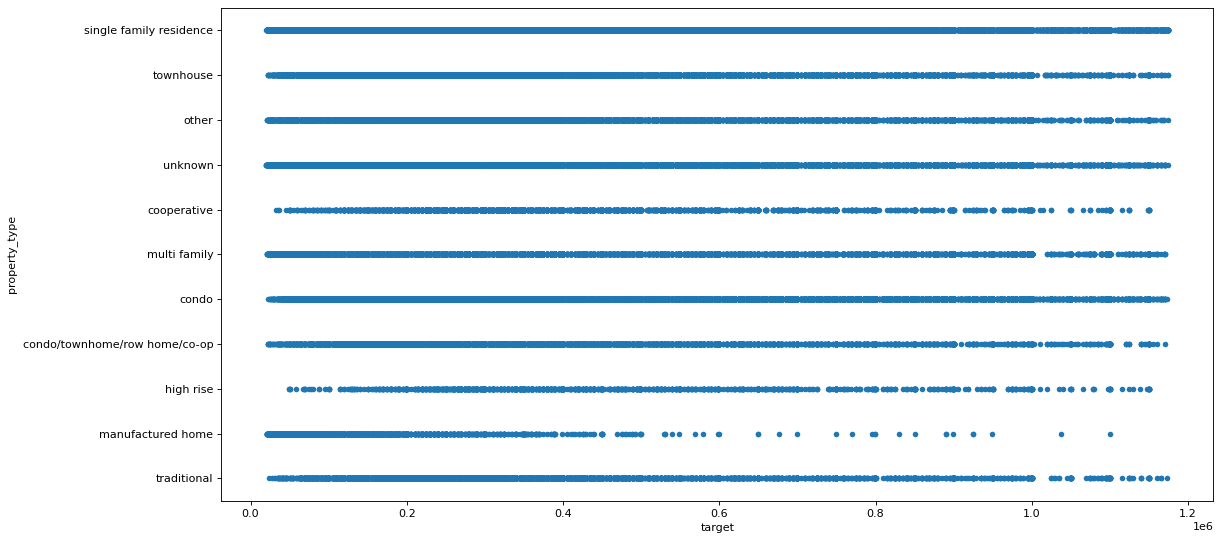

In [74]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=80)
sns.stripplot(data=data, x="target", y="property_type", dodge=True, jitter=False)

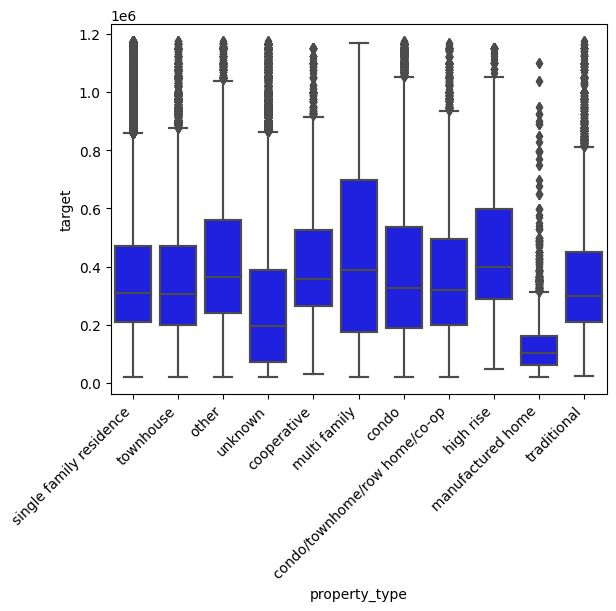

In [75]:
sns.boxplot(x='property_type', y='target', data=data)
sns.boxplot(
    x='property_type', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

> ***Выводы***

Признак "property_type" - был преобразован к 10 категориям, пропущенные значения были отнесены к "unknown". Значения, которые с точки зрения частотного распределения не вошли в топ10 были отнесены к "other".

В рамках обработки данных, так же отказалась от веделения отдельного признака стиль - так как 95% данных пустые, а значения которые есть крайне разнообразны и не позволяют выделить категории с относительно высокой долей от общего кол-ва.

Дополнительно, были обнаружены данные по кол-ву этажей, за счет этого были обогащены данные с соотвествующем столбце (там где были пропущенные значения)

#### 4.8 Признак "home_facts"

In [76]:
# Посмотрим 1 строку - чтобы оценить какие параметры есть
data.home_facts[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

In [77]:
# выведем кол-во уникальных значений в столбце
data.home_facts.nunique()

281102

In [78]:
# выведем кол-во пустых значений
data.home_facts.isna().sum()

0

In [79]:
# Применим функцию eval для раскодировки словаря
data.home_facts = data.home_facts.apply(eval)

In [80]:
# Получим данные по году постройки
data['year_house_builtt'] = data['home_facts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])

In [81]:
# Кол-во уникальных значений
data.year_house_builtt.nunique()

221

In [82]:
# Кол-во пустых строк
data.year_house_builtt.isna().sum()

2939

In [83]:
# Выведем уникальные значения для визуальной оценки
data.year_house_builtt.unique()

array(['2019', '1920', '2006', '1976', '1970', '1965', '2015', '1996',
       '1982', '2008', '2016', '1954', '1989', '2014', '', '1994', '1910',
       '1960', '1977', '1972', '1963', '1981', '1949', '1930', '1991',
       '1958', '2017', '1983', '1928', '1998', '1997', '1964', '1974',
       '1940', '1973', '1968', '1999', '1918', '2007', '1984', '1946',
       '2003', '2000', '2004', '1969', '2002', '1952', '1961', '1947',
       '1957', '1978', '1956', '1967', '1975', '1988', '1950', '1959',
       '2012', '1924', '1966', '2005', '1992', '2001', '1995', '2018',
       '1955', '1971', '1909', '1953', '1993', '1990', '1980', '1985',
       '1915', '1951', '1907', '1885', '1941', '1927', '1929', None,
       '1922', '1906', '1945', '1962', '1979', '1913', '2011', '1897',
       '1987', '2020', '1926', '1939', '2013', '1986', 'No Data', '1943',
       '1935', '1925', '1890', '1895', '1911', '1948', '1942', '1916',
       '1900', '2010', '2009', '1931', '1944', '1893', '1879', '1914',
 

Text(0, 0.5, 'count')

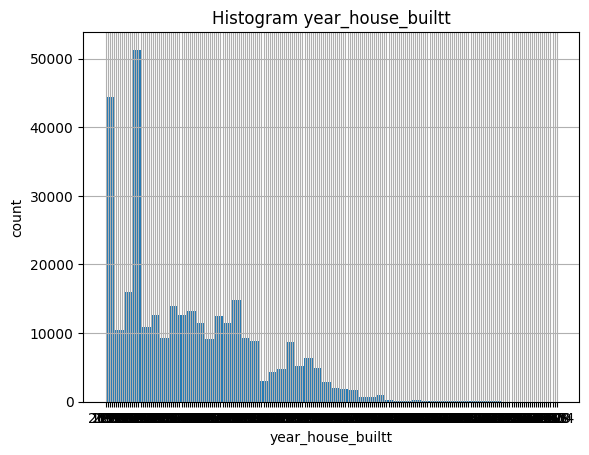

In [84]:
# Построим гистограмму для оценки распределения
data["year_house_builtt"].hist(bins=50)
plt.title('Histogram year_house_builtt')
plt.xlabel('year_house_builtt')
plt.ylabel('count')

In [85]:
#Преобразуем значения None на No Data и преобразуем выбросы
data = data.drop(data[(data.year_house_builtt == '559990649990') | (data.year_house_builtt == '1')].index)
data.reset_index(inplace = True, drop = True)
data.year_house_builtt = data.year_house_builtt.apply(lambda x: None if (x == '') | (x == 'No Data') else x)
data.year_house_builtt = data.year_house_builtt.apply(lambda x: int(x) if x != None else x)
data.year_house_builtt.unique()

array([2019., 1920., 2006., 1976., 1970., 1965., 2015., 1996., 1982.,
       2008., 2016., 1954., 1989., 2014.,   nan, 1994., 1910., 1960.,
       1977., 1972., 1963., 1981., 1949., 1930., 1991., 1958., 2017.,
       1983., 1928., 1998., 1997., 1964., 1974., 1940., 1973., 1968.,
       1999., 1918., 2007., 1984., 1946., 2003., 2000., 2004., 1969.,
       2002., 1952., 1961., 1947., 1957., 1978., 1956., 1967., 1975.,
       1988., 1950., 1959., 2012., 1924., 1966., 2005., 1992., 2001.,
       1995., 2018., 1955., 1971., 1909., 1953., 1993., 1990., 1980.,
       1985., 1915., 1951., 1907., 1885., 1941., 1927., 1929., 1922.,
       1906., 1945., 1962., 1979., 1913., 2011., 1897., 1987., 2020.,
       1926., 1939., 2013., 1986., 1943., 1935., 1925., 1890., 1895.,
       1911., 1948., 1942., 1916., 1900., 2010., 2009., 1931., 1944.,
       1893., 1879., 1914., 1937., 1905., 1912., 1938., 1921., 1860.,
       1936., 1923., 1908., 1865., 1917., 1898., 1899., 1934., 1880.,
       1700., 1904.,

In [86]:
# Заполним пропущенные значения медианой
year_house_builtt_median = round(data.year_house_builtt.median())
data['year_house_builtt'] = data['year_house_builtt'].fillna(year_house_builtt_median)

In [87]:
# Выведем список уникальных значений
data.year_house_builtt.unique()

array([2019., 1920., 2006., 1976., 1970., 1965., 2015., 1996., 1982.,
       2008., 2016., 1954., 1989., 2014., 1985., 1994., 1910., 1960.,
       1977., 1972., 1963., 1981., 1949., 1930., 1991., 1958., 2017.,
       1983., 1928., 1998., 1997., 1964., 1974., 1940., 1973., 1968.,
       1999., 1918., 2007., 1984., 1946., 2003., 2000., 2004., 1969.,
       2002., 1952., 1961., 1947., 1957., 1978., 1956., 1967., 1975.,
       1988., 1950., 1959., 2012., 1924., 1966., 2005., 1992., 2001.,
       1995., 2018., 1955., 1971., 1909., 1953., 1993., 1990., 1980.,
       1915., 1951., 1907., 1885., 1941., 1927., 1929., 1922., 1906.,
       1945., 1962., 1979., 1913., 2011., 1897., 1987., 2020., 1926.,
       1939., 2013., 1986., 1943., 1935., 1925., 1890., 1895., 1911.,
       1948., 1942., 1916., 1900., 2010., 2009., 1931., 1944., 1893.,
       1879., 1914., 1937., 1905., 1912., 1938., 1921., 1860., 1936.,
       1923., 1908., 1865., 1917., 1898., 1899., 1934., 1880., 1700.,
       1904., 1932.,

In [88]:
# Удалим выбросы
data = data.drop(outliers_iqr(data.year_house_builtt))
data.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'count')

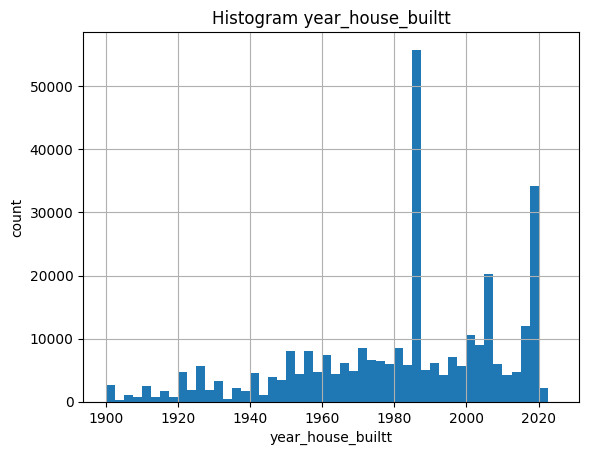

In [89]:
# Построим гистограмму для оценки распределения
data["year_house_builtt"].hist(bins=50)
plt.title('Histogram year_house_builtt')
plt.xlabel('year_house_builtt')
plt.ylabel('count')

In [90]:
# Выделим год реконструкции
data['remodeled_year'] = data['home_facts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])

In [91]:
# Выведем кол-во уникальных значений
data.remodeled_year.nunique()

128

In [92]:
# Кол-во уникальных значений
data.remodeled_year.isna().sum()

22289

In [93]:
# Выведем список уникальных значений для визуальной оценки
data.remodeled_year.unique()

array(['', '2006', None, '2015', '1997', '2019', '1982', '2009', '1996',
       '1995', '1988', '1972', '1949', '1954', '1930', '2003', '2000',
       '1994', '1983', '1965', '1968', '1993', '2008', '2010', '2004',
       '2007', '2002', '1952', '1978', '2014', '1975', '1971', '1947',
       '1957', '1967', '1973', '1970', '2016', '1950', '1989', '1998',
       '1955', '2005', '1991', '2011', '1980', '1999', '1986', '1941',
       '2001', '1990', '1979', '1984', '1918', '1977', '1962', '1956',
       '2013', '1960', '1981', '1987', '1958', '1964', '1966', '1992',
       '1925', '1961', '1931', '2012', '1976', '2017', '1974', '1935',
       '1910', '1940', '1969', '2018', '1916', '1914', '1963', '1985',
       '1951', '1944', '1942', '1959', '1927', '1946', '1948', '1945',
       '1920', '1938', '1936', '0', '1939', '1915', '1928', '1929',
       '1934', '1953', '1926', '1937', '1912', '1917', '1906', '1932',
       '1905', '1919', '1921', '1924', '1901', '1911', '1923', '1943',
       

In [94]:
data.remodeled_year = data.remodeled_year.apply(lambda x: '0' if x == '' else x)
data.remodeled_year = data.remodeled_year.fillna('0')
data.remodeled_year = data.remodeled_year.apply(lambda x: int(x))
data['remodeling'] = data.remodeled_year.apply(lambda x: 'yes' if x > 0 else 'no')
data.drop('remodeled_year', axis = 1, inplace = True)

Text(0, 0.5, 'count')

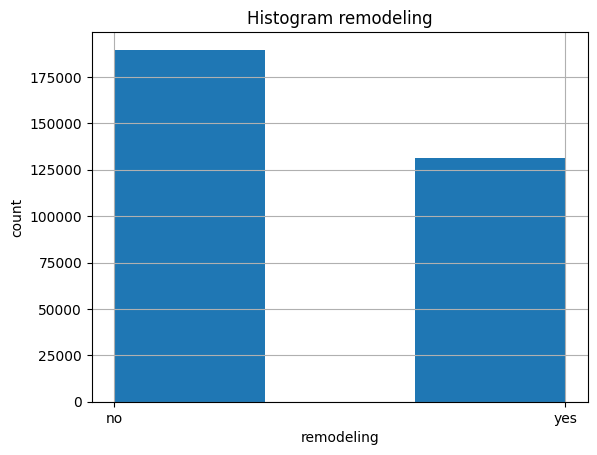

In [95]:
# Построим гистограмму для оценки распределения
data["remodeling"].hist(bins=3)
plt.title('Histogram remodeling')
plt.xlabel('remodeling')
plt.ylabel('count')

<AxesSubplot: xlabel='target', ylabel='remodeling'>

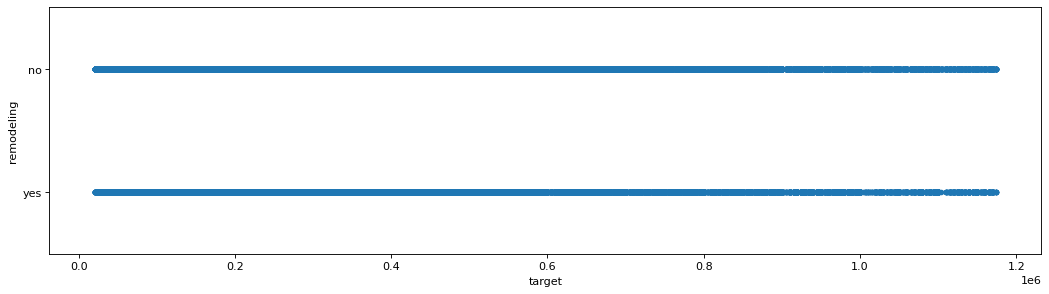

In [96]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=80)
sns.stripplot(data=data, x="target", y="remodeling", dodge=True, jitter=False)

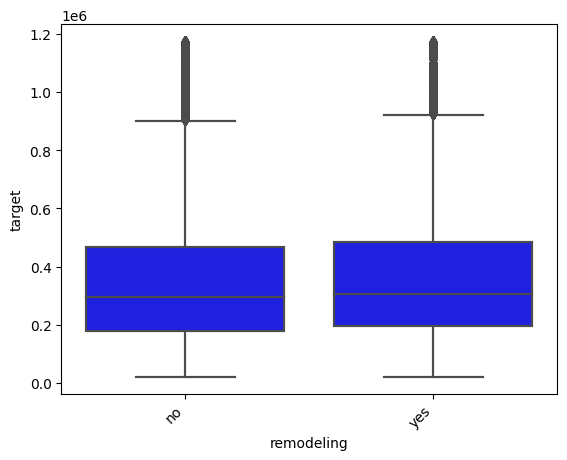

In [97]:
sns.boxplot(x='remodeling', y='target', data=data)
sns.boxplot(
    x='remodeling', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

In [98]:
data['cooling'] = data['home_facts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])

In [99]:
# Кол-во уникальных значений
data.cooling.nunique()

1253

In [100]:
# Выведем уникальные значения для визуальной оценки
data.cooling.unique()

array(['', 'Central', 'Central Air', ...,
       'Central Air, Electric Hot Air, Gas (Hot Air), Heat Pump for A/C, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat, Natural Gas',
       '90%+ High Efficiency, Ductless HP-Mini Split, Tankless Water Heater',
       'Central A/C (Gas), Central Heat (Gas), Heat Pump'], dtype=object)

In [101]:
data.drop('cooling', axis = 1, inplace = True)

> ***Выводы***

Данные в столбце cooling слишком грязные, имеют слишком не равномерное распределение стоимости по факторам. В рамках анализа было принято решение о удалении данного признака

In [102]:
data['parking'] = data['home_facts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])

In [103]:
# Кол-во уникальных значений
data.parking.nunique()

3049

In [104]:
# Кол-во пропущенных значений
data.parking.isna().sum()

2939

In [105]:
# Выведем ТОП 50 значений
data.parking.value_counts()[:50]

                                             143107
Attached Garage                               61185
2 spaces                                      25491
1 space                                       13159
No Data                                       11391
Detached Garage                               11267
Carport                                        7176
3 spaces                                       3770
Off Street                                     3154
Carport, Attached Garage                       2658
1                                              2639
2                                              2342
4 spaces                                       2184
None                                           1991
Off street                                     1392
Attached Garage, Detached Garage               1020
On Street                                      1012
Attached Garage, Carport                        872
Parking Desc                                    789
Driveway    

In [106]:
# Заменим пропущенные значения категорией no info
data['parking'] = data['parking'].fillna('no info')

In [107]:
# Приведем к нижнему регистру
data['parking'] =data['parking'].apply(lambda x: str(x).lower())

In [108]:
data['parking'] = data['parking'].apply(lambda x: 'no_info' if (x == '') | (x == 'no data') | (x == 'none') else x)
data['parking'] = data['parking'].apply(lambda x: '1_space' if (x == '1') else x)
data['parking'] = data['parking'].apply(lambda x: '2_spaces' if (x == '2') else x)
data['parking'] = data['parking'].apply(lambda x: 'other' if (x == 'carport') | (x == 'off street') | (x == 'off street parking') | 
                                    (x == 'on street') | (x == 'driveway') | (x == 'drvwy') | (x == 'driveway paved') else x)

In [109]:
pattern = re.compile('\d+')

# Создаём вспомогательный столбец 'n_spaces', в который запишем количество парковочных мест
data['n_spaces'] = data['parking'].apply(lambda x: int(pattern.findall(x)[0]) if len(pattern.findall(x)) > 0 else 0)

# Основываясь на информации в столбце 'n spaces' запишем значение 'more_than_2_spaces' в столбец parking там где количество 
# парковочных мест больше двух
for i in data.index:
    if data['n_spaces'].loc[i] > 2:
        data['parking'].loc[i] = 'more_than_2_spaces'
    else:
        continue

# Удалим столбец 'n spaces'
data.drop('n_spaces', axis = 1, inplace = True)

In [110]:
# Подберем оптимальное кол-во категорий, с точки зрения объема данных и кол-во уникальных категорий методом перебора
parkingTypes_with_freqs = list(data.parking.value_counts())
top_parkingTypes_count = int(np.percentile(parkingTypes_with_freqs, 89))
top_parkingTypes_count

7

In [111]:
# Приведем к виду 7 категорий
all_parkingTypes = set(data.parking.value_counts().index)
main_parkingTypes = set(data.parking.value_counts().index[:7])
parkingTypes_to_drop = list(all_parkingTypes - main_parkingTypes)
data.drop(data.loc[data['parking'].isin(parkingTypes_to_drop), 'parking'].index, inplace = True)

data.reset_index(inplace = True, drop = True)

In [112]:
# Выведем долю каждой категории от общего кол-ва
data["parking"].value_counts(normalize=True).round(4).head(50) * 100

no_info               53.76
attached garage       21.02
2 spaces               8.76
other                  4.94
1 space                4.52
detached garage        3.87
more_than_2_spaces     3.13
Name: parking, dtype: float64

<AxesSubplot: xlabel='target', ylabel='parking'>

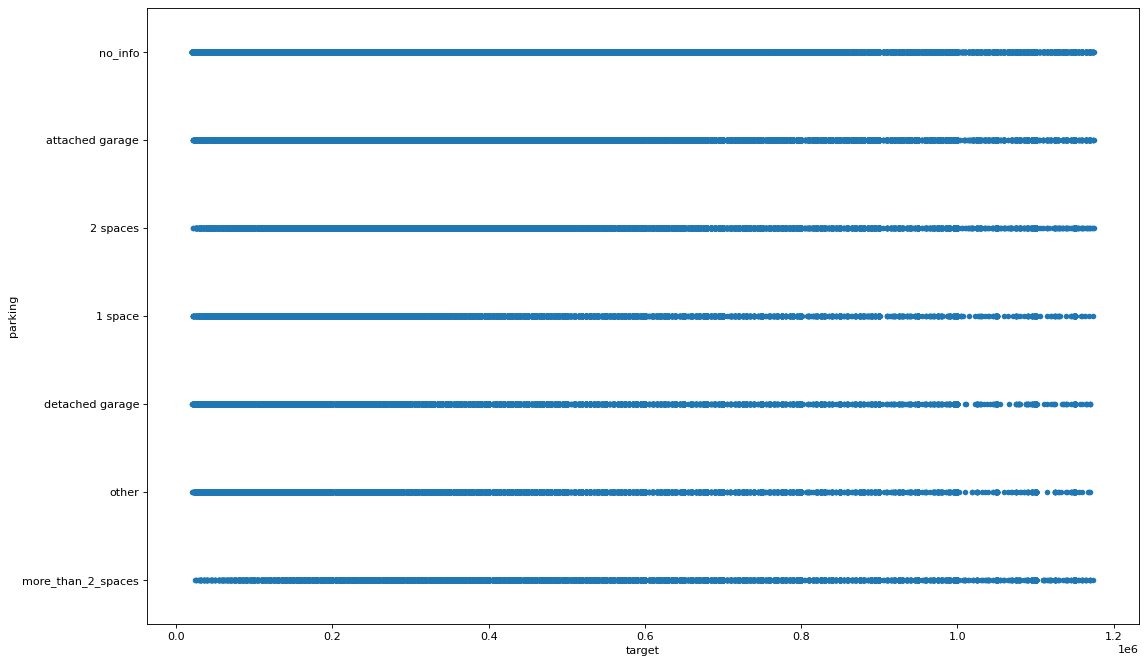

In [113]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=80)
sns.stripplot(data=data, x="target", y="parking", dodge=True, jitter=False)

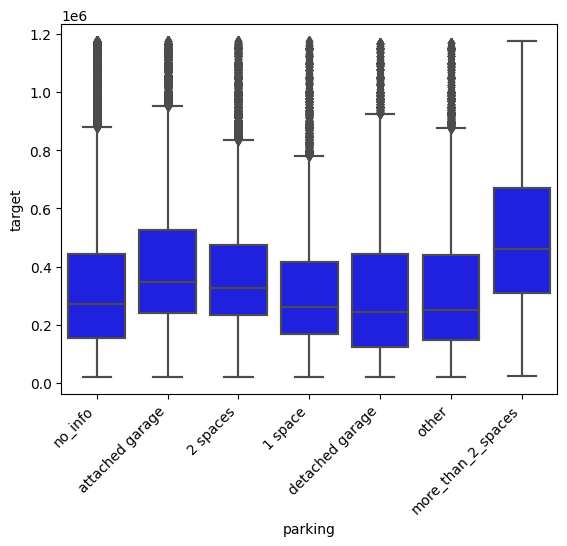

In [114]:
sns.boxplot(x='parking', y='target', data=data)
sns.boxplot(
    x='parking', 
    y='target', 
    data=data, 
    color='blue')
plt.xticks(rotation=45, 
           ha='right');

In [115]:
# Извлечени данные по стоимости земли
data['price_sqft'] = data['home_facts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

In [116]:
# Выведем кол-во уникальных значений
data['price_sqft'].nunique()

3645

In [117]:
# Выведем кол-во пустых значений
data['price_sqft'].isna().sum()

37910

In [118]:
data.drop('price_sqft', axis = 1, inplace = True)

> ***Выводы***

Признак price/sqft содердит большое кол-во пропущенных значений и признак характерен только для домов с земельным участком. Так как данные "грязные" - принято решено о его удалении.
По этому признаку также может наблюдаться "утечка данных"

In [119]:
data.drop('home_facts', axis = 1, inplace = True)

> ***Выводы***



#### 4.9 Признак "schools"

In [120]:
# Выведем строку, которая покажем состав свойств
data.schools[0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [121]:
# выведем кол-во уникальных значений в столбце
data.schools.nunique()

231038

In [122]:
# выведем кол-во пустых значений
data.schools.isna().sum()

0

In [123]:
# Применим функцию eval для раскодировки словаря
data.schools = data.schools.apply(eval)

In [124]:
data['average_school_rating'] = data['schools'].apply(lambda x: x[0]['rating'])

In [125]:
# С помощью регулярного выражения обработаем данные
pattern = re.compile('\d+')

for i in data.index:
    sum_ratings = 0
    count = 0
    for item in data['average_school_rating'].loc[i]:
        if (len(pattern.findall(item)) != 0) & ('None' not in item):
            sum_ratings += int(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        data['average_school_rating'].loc[i] = 0
    else:
        data['average_school_rating'].loc[i] = round(sum_ratings/count, 1)

In [126]:
# Заполним 0 медианным значением
round(data[data['average_school_rating'] != 0]['average_school_rating'].median())
data['average_school_rating'] = data['average_school_rating'].apply(lambda x: 5 if x == 0 else x)

Text(0, 0.5, 'count')

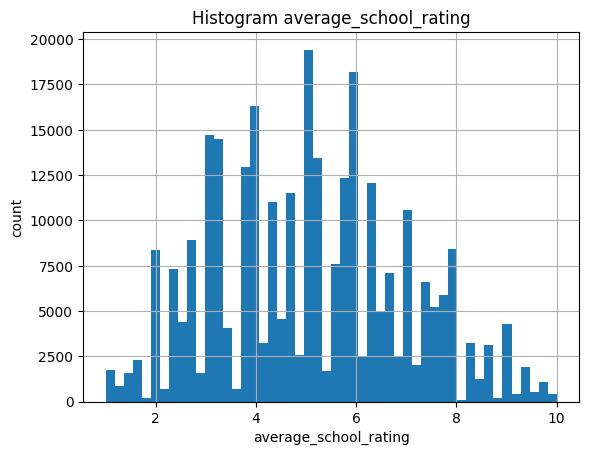

In [127]:
# Построим гистограмму для оценки распределения
data["average_school_rating"].hist(bins=50)
plt.title('Histogram average_school_rating')
plt.xlabel('average_school_rating')
plt.ylabel('count')

In [128]:
data['number_of_schools'] = data['schools'].apply(lambda x: len(x[0]['rating']))

In [129]:
data['number_of_schools'] = data['number_of_schools'].apply(lambda x: 3 if x == 0 else x)
data['number_of_schools'].value_counts()

3     173744
2      28382
8      23012
5      22699
4      18428
6       7803
1       6510
7       3885
24      1667
10       672
13       610
63       577
11       527
9        469
22       419
12       385
65       332
14       316
49       216
15       198
61       117
21        43
16        38
26         8
17         5
Name: number_of_schools, dtype: int64

In [130]:
# Удалим выбросы 
data.drop(outliers_z_score(data['number_of_schools'], threshold = 2), inplace = True)
data.reset_index(inplace = True, drop = True)

In [131]:
data['number_of_schools'].value_counts()

3     173744
2      28382
8      23012
5      22699
4      18428
6       7803
1       6510
7       3885
10       672
13       610
11       527
9        469
12       385
Name: number_of_schools, dtype: int64

Text(0, 0.5, 'count')

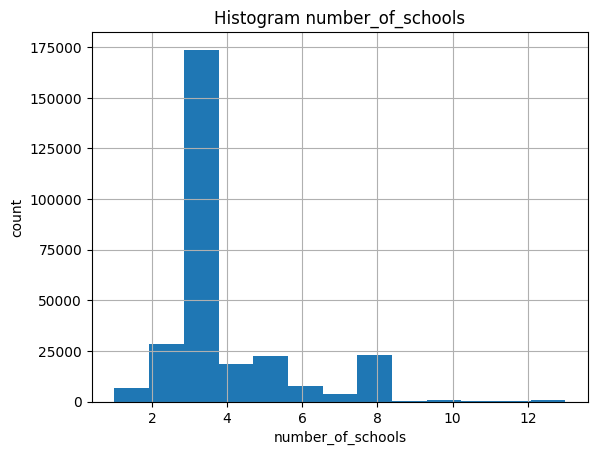

In [132]:
# Построим гистограмму для оценки распределения
data["number_of_schools"].hist(bins=13)
plt.title('Histogram number_of_schools')
plt.xlabel('number_of_schools')
plt.ylabel('count')

In [133]:
data['average_distance_to_school'] = data['schools'].apply(lambda x: x[0]['data']['Distance'])

In [134]:
data['average_distance_to_school'].isna().sum()

0

In [135]:
pattern = re.compile('\d+[.]\d+')

for i in data.index:
    sum_distances = 0
    count = 0
    for item in data['average_distance_to_school'].loc[i]:
        if len(pattern.findall(item)) != 0:
            sum_distances += float(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        data['average_distance_to_school'].loc[i] = 0
    else:
        data['average_distance_to_school'].loc[i] = round(sum_distances/count, 1)

In [136]:
round(data[data['average_distance_to_school'] != 0]['average_distance_to_school'].median())
data['average_distance_to_school'] = data['average_distance_to_school'].apply(lambda x: 2 if x == 0 else x)

In [137]:
# Удалим выбросы
data = data.drop(outliers_iqr(data.average_distance_to_school))
data.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'count')

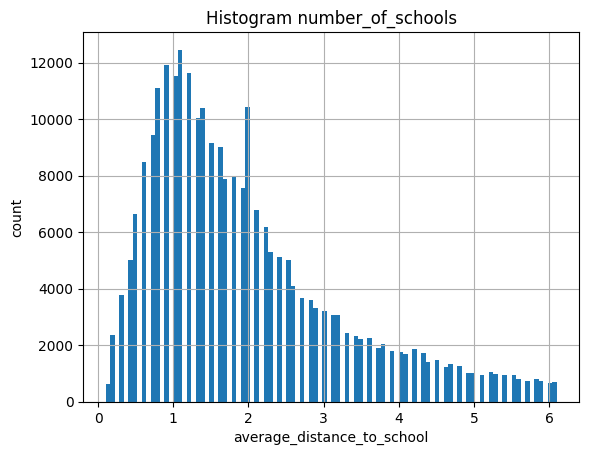

In [138]:
# Построим гистограмму для оценки распределения
data["average_distance_to_school"].hist(bins=100)
plt.title('Histogram number_of_schools')
plt.xlabel('average_distance_to_school')
plt.ylabel('count')

In [139]:
data.drop('schools', axis = 1, inplace = True)

#### 4.10 Признак "sqft"

In [140]:
# выведем кол-во уникальных значений в столбце
data.sqft.nunique()

18408

In [141]:
# выведем кол-во пустых значений
data.sqft.isna().sum()

22868

In [142]:
data['sqft'] = data['sqft'].apply(lambda x: '1847' if (x == '0') | (x == '--') | (x == '-- sqft') | (pd.isna(x) == True) else x)

In [143]:
pattern = re.compile('\d+[,]?\d+')

# Выделяем числовые значения и заполняем средне арифметическим
data['sqft'] = data['sqft'].apply(lambda x: '1847' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

# Убираем запятые
data['sqft'] = data['sqft'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
data['sqft'] = data['sqft'].apply(lambda x: int(x))

In [144]:
# Выведем статистическую информацию 
data.sqft.describe()

count    2.595810e+05
mean     4.320769e+03
std      8.962837e+05
min      1.000000e+01
25%      1.350000e+03
50%      1.847000e+03
75%      2.348000e+03
max      4.566025e+08
Name: sqft, dtype: float64

In [145]:
# Удалим  выбросы
data.drop(outliers_iqr(data.sqft), inplace = True)
data.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'count')

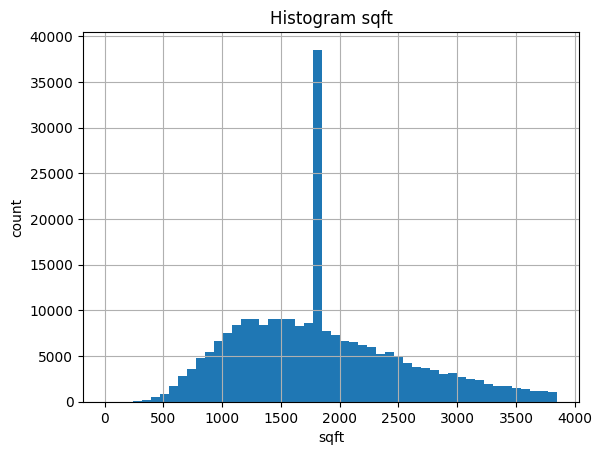

In [146]:
# Построим гистограмму для оценки распределения
data["sqft"].hist(bins=50)
plt.title('Histogram sqft')
plt.xlabel('sqft')
plt.ylabel('count')

In [147]:
# Удалим данные менее 300 квадратных футов, так как это менее 27 квадратных метров
data = data.query('sqft > 300')

> ***Выводы***

Произведено очистка данных и заполнение среднеарифметическим значением. Данные очищены от выбросов. 

#### 4.11 Признак "beds"

In [148]:
# выведем кол-во уникальных значений в столбце
data.beds.nunique()

87

In [149]:
data.beds.isna().sum()

58589

In [150]:
data.drop('beds', axis = 1, inplace = True)

> ***Выводы***

Данные слишком грязные, столбец содердит разрозненую информацию по различным признакам. При визуальной оценке популярных значений видно, что значительный объем данных не относится к данному признаку. Приняла решение удалить данный признак.

#### 4.12 Признак "stories"

In [151]:
# Выведем кол-во уникальных значений
data.stories.nunique()

263

In [152]:
# Выведем кол-во пропущенных значений
data.stories.isna().sum()

84073

In [153]:
data.drop('stories', axis = 1, inplace = True)

> ***Выводы***

Данные слишком грязные и содержат большое кол-во пропущенных значений (104 909 штук). Приняла решение удалить данный признак.

In [154]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

Исходя из графиков, каждый категориальный признак может оказывать влияние на целевую переменную. Проверим, есть ли статистическая разница в распределении категориальных признаков с помощью теста Стьюдента

In [159]:
# Составим список категориальных признаков:
cat_features = ['status','property_type', 'fireplace', 'city', 'state', 'private_pool', 'remodeling', 'parking']

In [174]:
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'target'], 
                        data.loc[data.loc[:, column] == comb[1], 'target']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
for col in chain(cat_features):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки status
Найдены статистически значимые различия для колонки property_type
Найдены статистически значимые различия для колонки fireplace
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки state
Найдены статистически значимые различия для колонки private_pool
Найдены статистически значимые различия для колонки remodeling
Найдены статистически значимые различия для колонки parking


Все признаки являются значимыми

In [ ]:
#удалим дубликаты
data = data.drop_duplicates(ignore_index=True)

In [ ]:
data.head()

,status,property_type,baths,fireplace,city,sqft,state,private_pool,target,year_house_builtt,remodeling,parking,average_school_rating,number_of_schools,average_distance_to_school
0,active,single family residence,4,yes,other,2900,NC,no,418000,2019.0,no,no_info,5.2,8,5.5
1,for sale,single family residence,3,no,other,1947,WA,no,310000,2019.0,no,no_info,4.0,3,1.3
2,for sale,townhouse,0,no,philadelphia,897,other,no,209000,1920.0,no,no_info,5.0,3,2.0
3,active,other,0,no,other,1507,FL,no,181500,2006.0,yes,no_info,2.3,4,3.8
4,active,unknown,0,no,other,1847,TN,no,68000,1976.0,no,no_info,2.7,3,1.1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243616 entries, 0 to 243615
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status                      243616 non-null  object 
 1   property_type               243616 non-null  object 
 2   baths                       243616 non-null  int32  
 3   fireplace                   243616 non-null  object 
 4   city                        243616 non-null  object 
 5   sqft                        243616 non-null  int64  
 6   state                       243616 non-null  object 
 7   private_pool                243616 non-null  object 
 8   target                      243616 non-null  int64  
 9   year_house_builtt           243616 non-null  float64
 10  remodeling                  243616 non-null  object 
 11  parking                     243616 non-null  object 
 12  average_school_rating       243616 non-null  float64
 13  number_of_scho

In [ ]:
data.to_csv('D:\IDE\диплом\diplom\project\data3.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243616 entries, 0 to 243615
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status                      243616 non-null  object 
 1   property_type               243616 non-null  object 
 2   baths                       243616 non-null  int32  
 3   fireplace                   243616 non-null  object 
 4   city                        243616 non-null  object 
 5   sqft                        243616 non-null  int64  
 6   state                       243616 non-null  object 
 7   private_pool                243616 non-null  object 
 8   target                      243616 non-null  int64  
 9   year_house_builtt           243616 non-null  float64
 10  remodeling                  243616 non-null  object 
 11  parking                     243616 non-null  object 
 12  average_school_rating       243616 non-null  float64
 13  number_of_scho